# Imports

In [2]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [4]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [5]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [6]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [7]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [9]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [18]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [12]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
157/157 [==============================] - 325s 2s/step - loss: 0.6840 - accuracy: 0.7223 - val_loss: 0.8078 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 320s 2s/step - loss: 0.3115 - accuracy: 0.8854 - val_loss: 3.1897 - val_accuracy: 0.5035
Epoch 3/75
157/157 [==============================] - 320s 2s/step - loss: 0.2723 - accuracy: 0.8900 - val_loss: 7.7430 - val_accuracy: 0.5105
Epoch 4/75
157/157 [==============================] - 322s 2s/step - loss: 0.1863 - accuracy: 0.9272 - val_loss: 1.9258 - val_accuracy: 0.7830
Epoch 5/75
157/157 [==============================] - 320s 2s/step - loss: 0.1845 - accuracy: 0.9255 - val_loss: 6.3574 - val_accuracy: 0.5075
Epoch 6/75
157/157 [==============================] - 321s 2s/step - loss: 0.1621 - accuracy: 0.9342 - val_loss: 6.8115 - val_accuracy: 0.5010
Epoch 7/75
157/157 [==============================] - 322s 2s/step - loss: 0.1393 - accuracy: 0.9467 - val_loss: 18.1589 - val_accuracy: 0.500

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


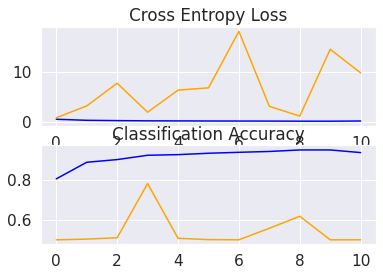

In [13]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [14]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

Epoch 1/75
157/157 [==============================] - 325s 2s/step - loss: 0.6509 - accuracy: 0.7311 - val_loss: 0.7626 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 322s 2s/step - loss: 0.2828 - accuracy: 0.8948 - val_loss: 1.1368 - val_accuracy: 0.5205
Epoch 3/75
157/157 [==============================] - 323s 2s/step - loss: 0.2081 - accuracy: 0.9193 - val_loss: 7.0600 - val_accuracy: 0.5000
Epoch 4/75
157/157 [==============================] - 324s 2s/step - loss: 0.1975 - accuracy: 0.9248 - val_loss: 2.2343 - val_accuracy: 0.6150
Epoch 5/75
157/157 [==============================] - 323s 2s/step - loss: 0.1721 - accuracy: 0.9318 - val_loss: 4.2589 - val_accuracy: 0.5035
Epoch 6/75
157/157 [==============================] - 322s 2s/step - loss: 0.1479 - accuracy: 0.9433 - val_loss: 4.2799 - val_accuracy: 0.5265
Epoch 7/75
157/157 [==============================] - 322s 2s/step - loss: 0.1407 - accuracy: 0.9437 - val_loss: 1.5828 - val_accuracy: 0.6585

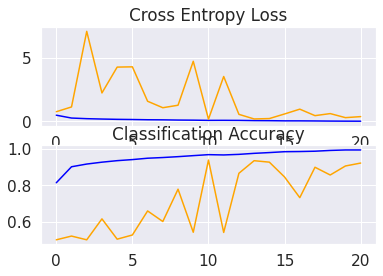

In [15]:
model_test_data, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization

In [19]:
def train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/100
 79/157 [==============>...............] - ETA: 2:49 - loss: 93.6640 - accuracy: 0.6633

### Train Data with Data Augmentation and Weight Regularization 

In [ ]:
def train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight, accuracy = train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 30)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))